## Aim

Compute an ABC occurrence rate estimate, and compare results with ```occurrence_mcmc```.

In [1]:
#!/bin/env python  
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import optimize, stats, linalg
from utils import dfm
from utils.abc import ABCSampler
# import astroabc

%load_ext autoreload
%autoreload 2

My ABC setup requires

- a prior for the model parameters $\theta$, i.e. a ```stats.continuous_rv/stats.discrete_rv``` object whose .rvs() method returns candidate parameters.
- a sampler for $f(x \mid \theta)$
- distance and statistic functions
- data to fit

I'm not 100% sure how any of these work.

In [2]:
kois = dfm.get_kois()
stellar = dfm.get_stellar()
kois = kois[kois["kepid"].isin(stellar["kepid"])]
# kois = dfm.kois_cuts(kois) - don't do the cuts! Not enough data to work with otherwise
# the only part of the cuts that is necessary is to get rid of NaN radii
kois = kois[np.isfinite(kois["koi_prad"])]

[192950   5222    508    153     59     21      2      2]


Text(0, 0.5, 'Counts')

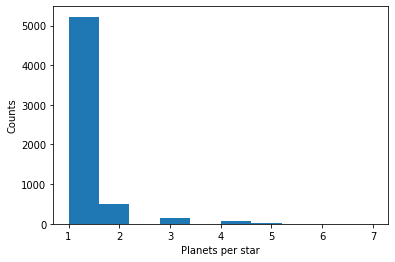

In [110]:
#starcounts = np.concatenate((np.array(pd.crosstab(index=kois['kepid'], columns="count")).flatten(), np.zeros((len(stellar[~stellar["kepid"].isin(kois["kepid"])]),))))
zerocounts = len(stellar[~stellar["kepid"].isin(kois["kepid"])])
solarsyssizes = np.array(pd.crosstab(index=kois['kepid'], columns="count")).flatten()
bincounts = np.bincount(starcounts)
bincounts[0] = zerocounts
print(bincounts)
plt.hist(starcounts)
plt.xlabel("Planets per star")
plt.ylabel("Counts")

Now the dataset has sufficient complexity to fit a Poisson process.

In [111]:
assert np.all(np.isfinite(kois["koi_prad"]))
assert np.all(np.isfinite(kois["koi_period"]))
koi_radii = kois["koi_prad"]
koi_periods = kois["koi_period"]

In [112]:
lam = np.mean(solarsyssizes)
lam = sum([i * k for i, k in enumerate(bincounts)]) / sum(bincounts)
planet_numbers = np.minimum(stats.poisson(lam).rvs(size=(len(stellar),)), 10)        

(array([1.91944e+05, 0.00000e+00, 0.00000e+00, 6.85700e+03, 0.00000e+00,
        0.00000e+00, 1.15000e+02, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

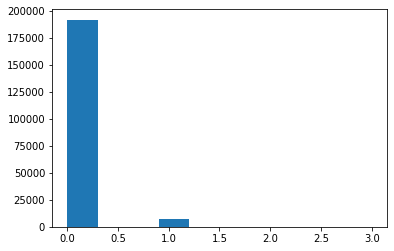

In [114]:
plt.hist(planet_numbers)

In [70]:
period = np.array([0.5, 1.25, 2.5, 5, 10, 20, 40, 80, 160, 320])
rp = np.array([0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 6, 8, 12, 16])
log_p, log_r = np.log(period), np.log(rp)
period_rng = (min(period), max(period))
rp_rng = (min(rp), max(rp))

f = np.histogram2d(koi_periods, koi_radii, bins=[period, rp])[0]
f /= np.sum(f)

In [66]:
len(rp)

14

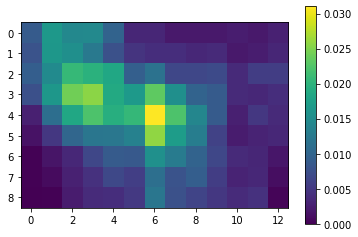

In [45]:
plt.imshow(f) # I guess that's sorta like an H-R diagram?
plt.colorbar()

In [103]:
bucket = np.random.choice(f.size, p=f.flatten())
i, j = bucket // f.shape[1], bucket % f.shape[1]
synth_p = np.exp(np.random.uniform(log_p[i], log_p[i+1]))
synth_r = np.exp(np.random.uniform(log_r[j], log_r[j+1]))
ecc = stats.rayleigh(0.03).rvs()
incl = np.cos(np.random.uniform(-1, 1))
print("Hey look I just made up a planet with period {0} days, radius {1} Earth radii, eccentricity {2}, orbital inclination {3}.".format(np.round(synth_p, 3), np.round(synth_r, 3), np.round(ecc, 3), np.round(incl, 3)))

Hey look I just made up a planet with period 3.928 days, radius 5.294 Earth radii, eccentricity 0.854, orbital inclination 0.659.


0.787643441189232

99

(array([  44., 3202., 2073.,  683.,  796.,  143.,   46.,   44.,   27.,
           6.]),
 array([-1.96611286, -0.60953531,  0.74704224,  2.10361979,  3.46019734,
         4.81677489,  6.17335244,  7.52992999,  8.88650754, 10.24308509,
        11.59966264]),
 <a list of 10 Patch objects>)

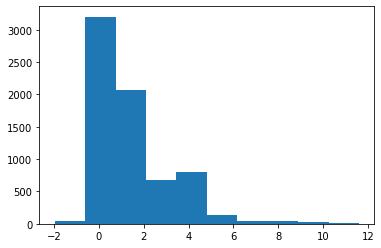

In [28]:
plt.hist(np.log(np.array(radii)))

(array([4.230e+02, 1.332e+03, 2.098e+03, 1.652e+03, 8.140e+02, 7.280e+02,
        1.600e+01, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-1.41946841, -0.09999584,  1.21947672,  2.53894929,  3.85842186,
         5.17789442,  6.49736699,  7.81683956,  9.13631212, 10.45578469,
        11.77525726]),
 <a list of 10 Patch objects>)

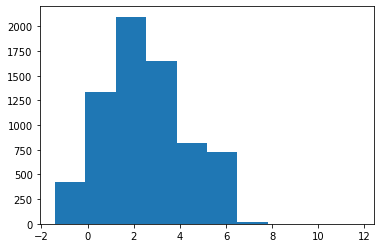

In [30]:
plt.hist(np.log(np.array(periods)))